In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque
from tensorflow.keras.utils import plot_model

import os
import numpy as np
import pandas as pd
import random

In [20]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [22]:
# Read Data
df = data.DataReader(['ZEEL.NS'], 'yahoo', start='2016/01/01', end='2022/07/13')
df = df['Close']
df.rename(columns={'ZEEL.NS': "Close"}, inplace = True)
df.head()

Symbols          Close
Date                  
2016-01-01  432.899994
2016-01-04  421.950012
2016-01-05  425.049988
2016-01-06  423.149994
2016-01-07  415.399994

In [23]:
df.tail()

Symbols          Close
Date                  
2022-07-07  223.050003
2022-07-08  223.850006
2022-07-11  224.149994
2022-07-12  220.800003
2022-07-13  223.100006

In [24]:
len(df)

1614

In [25]:
df.to_csv('zee.csv')

In [26]:
train = df[0:-132]
test = df[-132:]

In [27]:
train.tail()

Symbols          Close
Date                  
2021-12-27  317.950012
2021-12-28  321.500000
2021-12-29  317.950012
2021-12-30  318.100006
2021-12-31  320.799988

In [28]:
test.head()

Symbols          Close
Date                  
2022-01-03  322.950012
2022-01-04  322.350006
2022-01-05  319.049988
2022-01-06  324.549988
2022-01-07  320.799988

In [29]:
test.tail()

Symbols          Close
Date                  
2022-07-07  223.050003
2022-07-08  223.850006
2022-07-11  224.149994
2022-07-12  220.800003
2022-07-13  223.100006

In [30]:
len(train)

1482

In [31]:
len(test)

132

In [32]:
132/1614

0.08178438661710037

In [33]:
def load_data(df, n_steps=50, scale=True, lookup_step=1, 
                test_size=0.081784, feature_columns=['Close']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "Date" not in df.columns:
        df["Date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['Close'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["Date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
   
    # split the dataset into training & testing sets by date (not randomly splitting)
    train_samples = int((1 - test_size) * len(X))
    result["X_train"] = X[:train_samples]
    result["y_train"] = y[:train_samples]
    result["X_test"]  = X[train_samples:]
    result["y_test"]  = y[train_samples:]
        
    
        
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result        

In [34]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [35]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# N_STEPS = 101
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
#LOOKUP_STEP = 101
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"

# test ratio size, 0.2 is 20%
# TEST_SIZE = 0.2
TEST_SIZE = 0.081784

# features to use
FEATURE_COLUMNS = ["Close"]

### model parameters
N_LAYERS = 2

# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 100

# Amazon stock market
ticker = "ZEEL.NS"
# model name to save, making it as unique as possible based on parameters
if BIDIRECTIONAL:
    model_name += "-b"

In [36]:
import time

# load the data
data = load_data(df, N_STEPS, scale=SCALE,  
                lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
# data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# plot_model(model, to_file="multivariate_encoder_decoder_lstm_N_50.png", show_shapes="True")
# some tensorflow callbacks
#checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
#tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    verbose=1)

Epoch 1/100
23/23 [==============================] - 9s 284ms/step - loss: 0.0157 - mean_absolute_error: 0.1145 - val_loss: 0.0032 - val_mean_absolute_error: 0.0739
Epoch 2/100
23/23 [==============================] - 6s 259ms/step - loss: 0.0021 - mean_absolute_error: 0.0495 - val_loss: 6.9052e-04 - val_mean_absolute_error: 0.0306
Epoch 3/100
23/23 [==============================] - 6s 258ms/step - loss: 0.0017 - mean_absolute_error: 0.0430 - val_loss: 4.0579e-04 - val_mean_absolute_error: 0.0218
Epoch 4/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0016 - mean_absolute_error: 0.0423 - val_loss: 4.1342e-04 - val_mean_absolute_error: 0.0223
Epoch 5/100
23/23 [==============================] - 6s 253ms/step - loss: 0.0016 - mean_absolute_error: 0.0426 - val_loss: 4.0032e-04 - val_mean_absolute_error: 0.0219
Epoch 6/100
23/23 [==============================] - 6s 273ms/step - loss: 0.0014 - mean_absolute_error: 0.0398 - val_loss: 4.4108e-04 - val_mean_absolute_erro

23/23 [==============================] - 5s 231ms/step - loss: 0.0011 - mean_absolute_error: 0.0334 - val_loss: 3.2900e-04 - val_mean_absolute_error: 0.0199
Epoch 50/100
23/23 [==============================] - 6s 243ms/step - loss: 9.7649e-04 - mean_absolute_error: 0.0322 - val_loss: 3.0676e-04 - val_mean_absolute_error: 0.0190
Epoch 51/100
23/23 [==============================] - 6s 252ms/step - loss: 9.3592e-04 - mean_absolute_error: 0.0316 - val_loss: 2.1694e-04 - val_mean_absolute_error: 0.0154
Epoch 52/100
23/23 [==============================] - 6s 269ms/step - loss: 9.3557e-04 - mean_absolute_error: 0.0320 - val_loss: 2.2116e-04 - val_mean_absolute_error: 0.0154
Epoch 53/100
23/23 [==============================] - 6s 267ms/step - loss: 0.0010 - mean_absolute_error: 0.0335 - val_loss: 2.0868e-04 - val_mean_absolute_error: 0.0150
Epoch 54/100
23/23 [==============================] - 6s 253ms/step - loss: 9.1189e-04 - mean_absolute_error: 0.0316 - val_loss: 2.2667e-04 - val_mean_

23/23 [==============================] - 6s 242ms/step - loss: 6.8403e-04 - mean_absolute_error: 0.0272 - val_loss: 1.8533e-04 - val_mean_absolute_error: 0.0138
Epoch 97/100
23/23 [==============================] - 5s 236ms/step - loss: 6.6386e-04 - mean_absolute_error: 0.0267 - val_loss: 2.1385e-04 - val_mean_absolute_error: 0.0153
Epoch 98/100
23/23 [==============================] - 6s 240ms/step - loss: 7.4531e-04 - mean_absolute_error: 0.0281 - val_loss: 2.4970e-04 - val_mean_absolute_error: 0.0170
Epoch 99/100
23/23 [==============================] - 5s 235ms/step - loss: 7.4690e-04 - mean_absolute_error: 0.0283 - val_loss: 2.1780e-04 - val_mean_absolute_error: 0.0154
Epoch 100/100
23/23 [==============================] - 5s 235ms/step - loss: 7.3375e-04 - mean_absolute_error: 0.0282 - val_loss: 1.8043e-04 - val_mean_absolute_error: 0.0136


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 256)           264192    
                                                                 
 dropout_2 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


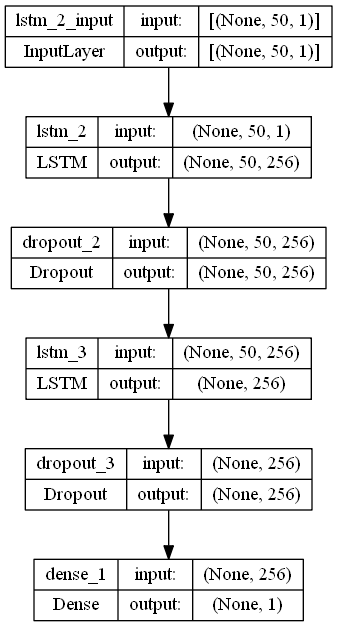

In [38]:
plot_model(model, show_shapes="True")

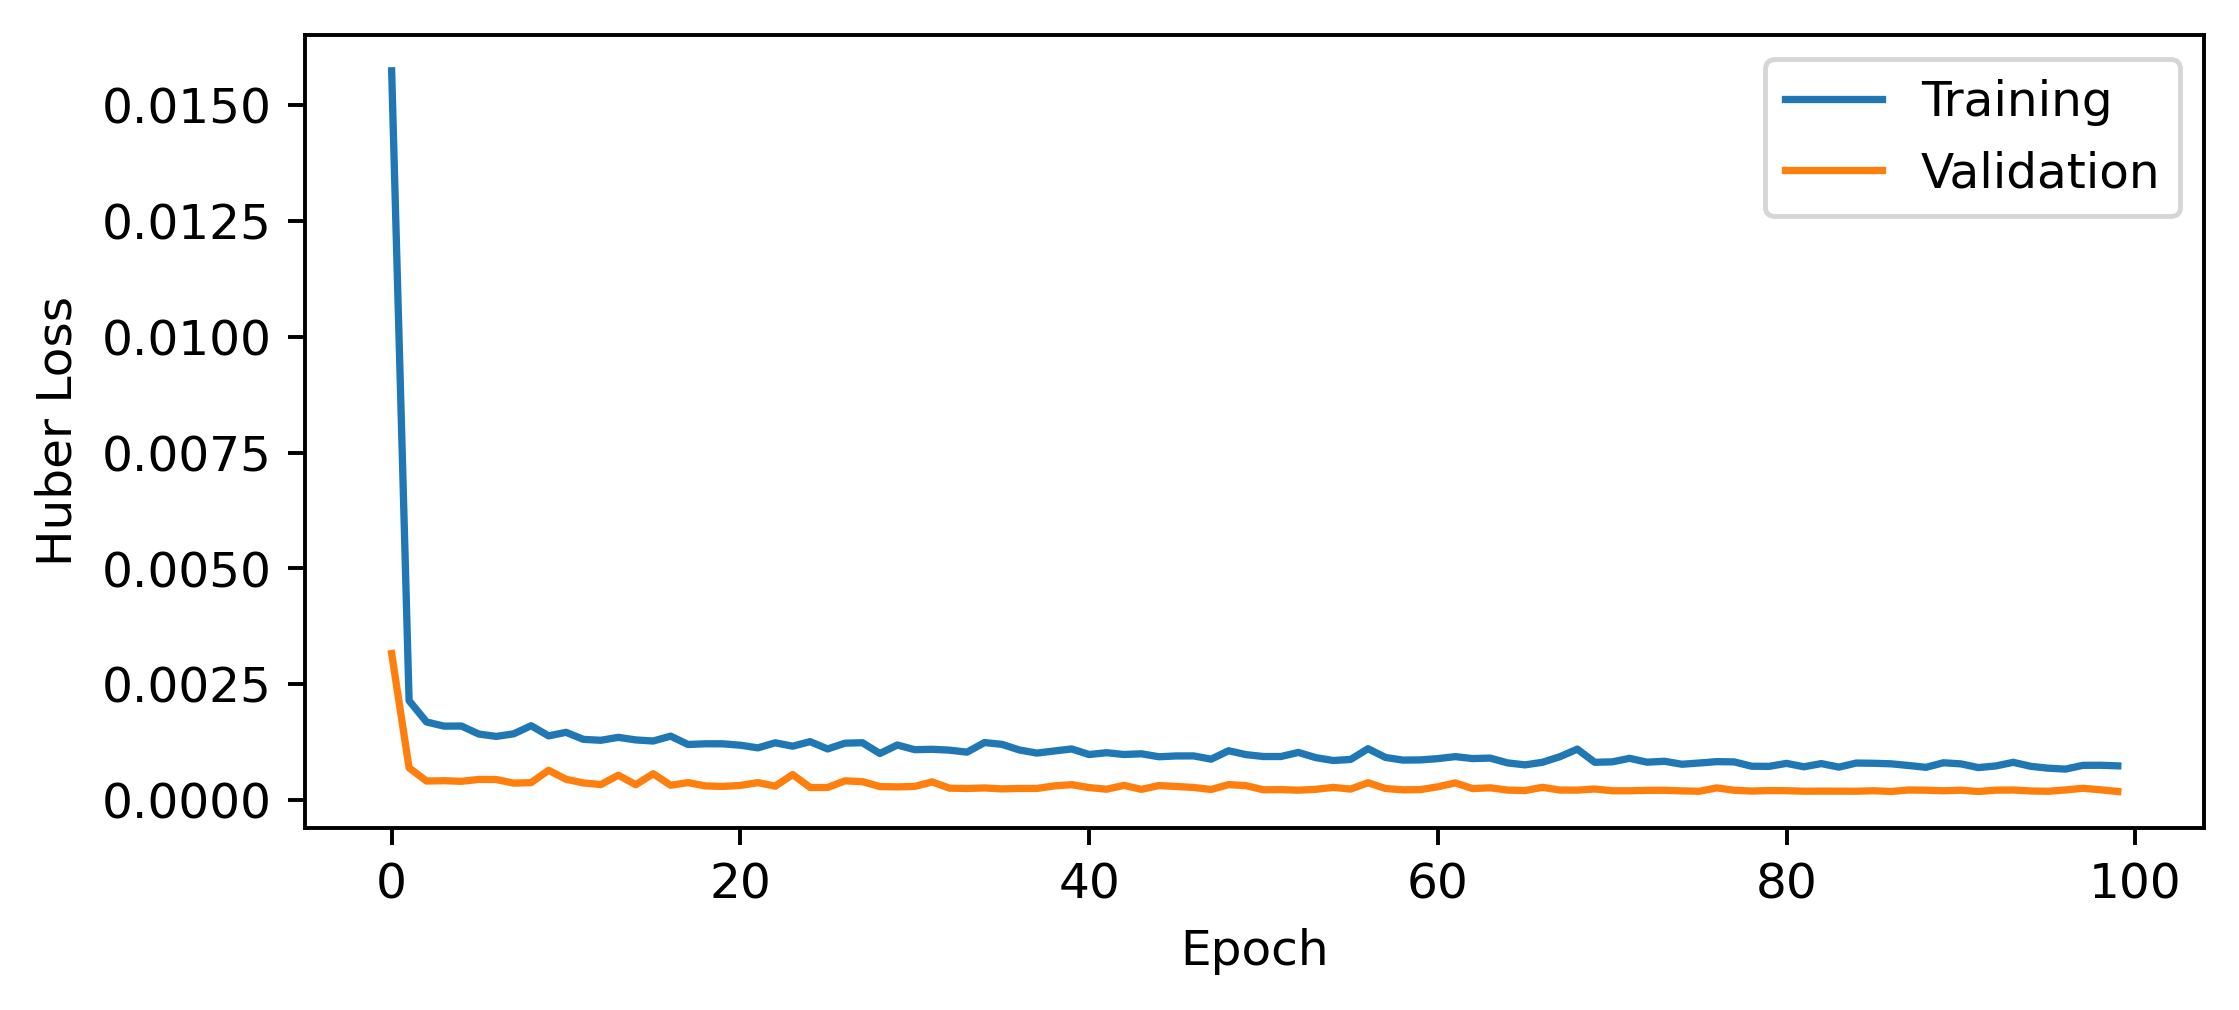

In [39]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=[7.0,3.0], dpi=350)
pyplot.plot(history.history['loss'], label='Training')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.xlabel('Epoch')
pyplot.ylabel('Huber Loss')
pyplot.legend()
pyplot.show()

In [40]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_Close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'Close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [41]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset 
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["Close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["Close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"Close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_Close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add predicted future prices to the dataframe
    test_df[f"Close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_Close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["Close"], 
                                    final_df[f"Close_{LOOKUP_STEP}"], 
                                    final_df[f"true_Close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["Close"], 
                                    final_df[f"Close_{LOOKUP_STEP}"], 
                                    final_df[f"true_Close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [42]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["Close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [43]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["Close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

print('Mean Absolute ErrorE: %.3f' % mean_absolute_error)

Mean Absolute ErrorE: 125.856


In [44]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

4/4 [==============================] - 1s 60ms/step


In [45]:
from scipy.stats import pearsonr
# predict the future price
future_price = predict(model, data)

1/1 [==============================] - 1s 565ms/step


In [46]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [47]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f} Rupees")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 1 days is 222.30 Rupees
huber_loss loss: 0.0001804275088943541
Mean Absolute Error: 125.85602953419958
Accuracy score: 0.5546875
Total buy profit: 23.543746948242188
Total sell profit: 64.26188659667969
Total profit: 87.80563354492188
Profit per trade: 0.6859815120697021


In [48]:
# plot true/pred prices graph
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=[7.0,3.0], dpi=350)
plot_graph(final_df)

In [49]:
print(final_df.tail(10))

final_df.to_csv("zeel_trans.csv")

Symbols          Close     Close_1  true_Close_1  buy_profit  sell_profit
Date                                                                     
2022-06-29  212.899994  217.052094    214.100006    4.152100     0.000000
2022-06-30  214.100006  214.548889    215.300003    0.448883     0.000000
2022-07-01  215.300003  213.332428    219.199997   -1.967575     0.000000
2022-07-04  219.199997  214.542694    215.350006    0.000000     4.657303
2022-07-05  215.350006  214.953201    223.649994   -0.396805     0.000000
2022-07-06  223.649994  217.939835    223.050003    0.000000     5.710159
2022-07-07  223.050003  220.782913    223.850006   -2.267090     0.000000
2022-07-08  223.850006  222.851242    224.149994   -0.998764     0.000000
2022-07-11  224.149994  223.954620    220.800003    0.000000     0.195374
2022-07-12  220.800003  222.994400    223.100006    2.194397     0.000000
